In [1]:
%cd ..

/Users/antonbabenko/Projects/numerai


In [5]:
from pathlib import Path

import matplotlib
import numpy
import pandas
import random
import sklearn
import xgboost
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

In [6]:
data_dir = Path("data")
df_path = data_dir / "numerai_training_data.csv"

In [7]:
df = pandas.read_csv(df_path)
df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [8]:
# There are 501808 rows grouped into eras, and a single target (target)
df.shape

(501808, 314)

In [9]:
# There's 310 features
features = [c for c in df if c.startswith("feature")]
df["erano"] = df.era.str.slice(3).astype(int)
eras = df.erano
target = "target"
len(features)

310

In [10]:
# The features are grouped together into 6 types
feature_groups = {
    g: [c for c in df if c.startswith(f"feature_{g}")]
    for g in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]
}
feature_groups

{'intelligence': ['feature_intelligence1',
  'feature_intelligence2',
  'feature_intelligence3',
  'feature_intelligence4',
  'feature_intelligence5',
  'feature_intelligence6',
  'feature_intelligence7',
  'feature_intelligence8',
  'feature_intelligence9',
  'feature_intelligence10',
  'feature_intelligence11',
  'feature_intelligence12'],
 'wisdom': ['feature_wisdom1',
  'feature_wisdom2',
  'feature_wisdom3',
  'feature_wisdom4',
  'feature_wisdom5',
  'feature_wisdom6',
  'feature_wisdom7',
  'feature_wisdom8',
  'feature_wisdom9',
  'feature_wisdom10',
  'feature_wisdom11',
  'feature_wisdom12',
  'feature_wisdom13',
  'feature_wisdom14',
  'feature_wisdom15',
  'feature_wisdom16',
  'feature_wisdom17',
  'feature_wisdom18',
  'feature_wisdom19',
  'feature_wisdom20',
  'feature_wisdom21',
  'feature_wisdom22',
  'feature_wisdom23',
  'feature_wisdom24',
  'feature_wisdom25',
  'feature_wisdom26',
  'feature_wisdom27',
  'feature_wisdom28',
  'feature_wisdom29',
  'feature_wisdom

In [11]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return numpy.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return numpy.corrcoef(y_true, y_pred)[0,1]

In [12]:
# There are 120 eras numbered from 1 to 120
eras.describe()

count    501808.000000
mean         64.001987
std          33.332945
min           1.000000
25%          37.000000
50%          64.000000
75%          93.000000
max         120.000000
Name: erano, dtype: float64

<AxesSubplot:xlabel='erano'>

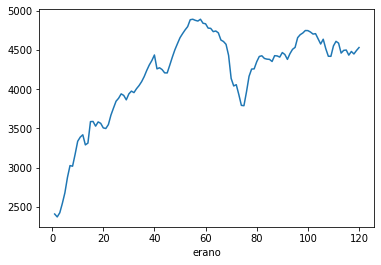

In [13]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [14]:
# The target is discrete and takes on 5 different values
df.groupby(target).size()

target
0.00     25016
0.25    100053
0.50    251677
0.75    100045
1.00     25017
dtype: int64

# Some of the features are very correlated
Especially within feature groups

In [15]:
feature_corrs = df[features].corr()

In [16]:
feature_corrs.stack().head()

feature_intelligence1  feature_intelligence1    1.000000
                       feature_intelligence2   -0.014157
                       feature_intelligence3   -0.024404
                       feature_intelligence4    0.652596
                       feature_intelligence5    0.069868
dtype: float64

In [17]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_constitution112  feature_constitution9    -0.855008
feature_constitution33   feature_constitution46   -0.830310
feature_constitution112  feature_constitution60   -0.820694
feature_constitution46   feature_constitution87   -0.815888
feature_constitution112  feature_constitution33   -0.759084
                                                     ...   
feature_constitution27   feature_constitution7     0.948920
feature_constitution13   feature_constitution79    0.949139
feature_wisdom31         feature_wisdom39          0.954984
feature_wisdom46         feature_wisdom7           0.963706
feature_wisdom12         feature_wisdom2           0.968062
Length: 47895, dtype: float64

### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [18]:
df1 = df[eras <= eras.median()]
df2 = df[eras > eras.median()]

In [19]:
corr1 = df1[features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [20]:
corr2 = df2[features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [21]:
tdf = pandas.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

corr1     corr2  corr_diff
feature_intelligence11 feature_intelligence9   0.091352 -0.128851  -0.220203
feature_dexterity12    feature_intelligence10  0.548931  0.343117  -0.205814
feature_dexterity9     feature_intelligence11  0.078715 -0.127070  -0.205785
feature_dexterity1     feature_dexterity12     0.653528  0.447942  -0.205587
feature_intelligence10 feature_intelligence11  0.075022 -0.130511  -0.205534
...                                                 ...       ...        ...
feature_intelligence8  feature_wisdom22       -0.088346  0.117772   0.206119
feature_intelligence4  feature_wisdom43       -0.102438  0.103758   0.206197
                       feature_wisdom33       -0.078930  0.133664   0.212593
feature_intelligence8  feature_wisdom43       -0.121306  0.115194   0.236501
                       feature_wisdom33       -0.091759  0.150549   0.242308

[47895 rows x 3 columns]

## Some features are predictive on their own

In [22]:
feature_scores = {
    feature: numerai_score(df[target], df[feature])
    for feature in features
}

In [23]:
pandas.Series(feature_scores).sort_values()

feature_dexterity7    -0.011505
feature_dexterity6    -0.011162
feature_dexterity4    -0.011051
feature_charisma69    -0.010221
feature_dexterity11   -0.010199
                         ...   
feature_charisma18     0.010698
feature_charisma19     0.010716
feature_charisma37     0.010892
feature_strength14     0.011609
feature_strength34     0.012488
Length: 310, dtype: float64

<AxesSubplot:>

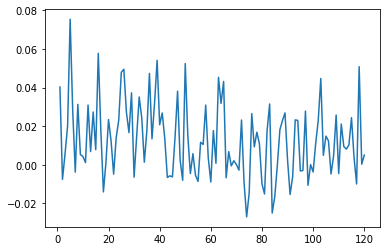

In [24]:
# Single features do not work consistently though
by_era_correlation = pandas.Series({
    era: numpy.corrcoef(tdf[target], tdf["feature_strength34"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

<AxesSubplot:>

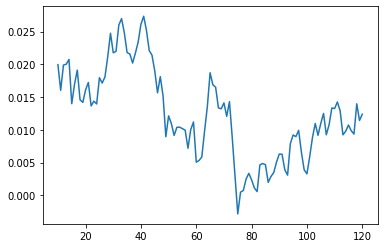

In [25]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than event the Mean-Squared-Error of the target (r-squared<0)

In [26]:
df1 = df[eras <= eras.median()]
df2 = df[eras > eras.median()]

In [27]:
linear1 = linear_model.LinearRegression()
linear1.fit(df1[features], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[features], df2[target])

LinearRegression()

In [28]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pandas.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.004093,-0.000543
train_on_2,0.000575,0.003155


In [29]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pandas.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pandas.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.062752,0.028026
train_on_2,0.032871,0.054796


In [30]:
# This can be be run with XGB as well

In [31]:
xgb1 = xgboost.XGBRegressor()
xgb1.fit(df1[features], df1[target])
xgb2 = xgboost.XGBRegressor()
xgb2.fit(df2[features], df2[target])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [xgb1, xgb2]
]
pandas.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.123117,-0.023794
train_on_2,-0.019996,0.127880


In [33]:
corrs = [
    [
        numerai_score(dfX[target], pandas.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [xgb1, xgb2]
]
pandas.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.403305,0.024816
train_on_2,0.022461,0.412005


# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, the 0-vs-rest and 1-vs-rest classifiers seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [34]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression()
logistic.fit(df[features], (df[target]*4).astype(int))
logistic.score(df[features], (df[target]*4).astype(int))

/Library/Python/3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5012315467270351

array([[ 1.        ,  0.46815296, -0.90388078,  0.42196907,  0.94725182],
       [ 0.46815296,  1.        , -0.7047161 ,  0.51720557,  0.42842072],
       [-0.90388078, -0.7047161 ,  1.        , -0.71842961, -0.91441732],
       [ 0.42196907,  0.51720557, -0.71842961,  1.        ,  0.49885228],
       [ 0.94725182,  0.42842072, -0.91441732,  0.49885228,  1.        ]])

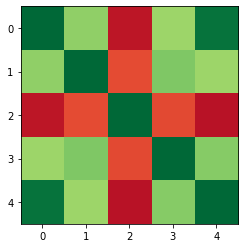

In [35]:
# The first and last class are highly correlated
corrs = numpy.corrcoef(logistic.predict_proba(df[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [36]:
# In-sample correlation is 5.4%
preds = pandas.Series(logistic.predict_proba(df[features]).dot(logistic.classes_), index=df.index)
numerai_score(df[target], preds)

0.050658832026110656

In [37]:
# A standard linear model has a slightly higher correlation
linear = linear_model.LinearRegression()
linear.fit(df[features], df[target])
linear.score(df[features], df[target])
preds = pandas.Series(linear.predict(df[features]), index=df.index)
numerai_score(df[target], preds)

0.051078039018326825

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of 4.3%, but a time series split reports a lower score of 3.4%

In [38]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    model_selection.TimeSeriesSplit(5)
]

In [39]:
def correlation_score(y_true, y_pred):
    return numpy.corrcoef(y_true, y_pred)[0,1]

In [40]:
for cv in crossvalidators:
    print(cv)
    print(numpy.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.033326245004552946

KFold(n_splits=5, random_state=None, shuffle=True)
0.041194585522362166

GroupKFold(n_splits=5)
0.03475937229926106

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.030947709608331663



## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 10, training on each block, and evaluating on each other block.

In [41]:
eras10 = (eras // 10) * 10
eras10.value_counts()

50     48186
60     46831
100    46107
90     45609
110    45070
80     43971
40     43439
30     41101
70     40403
20     37444
10     34600
0      24515
120     4532
Name: erano, dtype: int64

In [42]:
results10 = []
for train_era, tdf in df[eras10 < 120].groupby(eras10):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df[eras10 < 120].groupby(eras10):
        results10.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
10
20
30
40
50
60
70
80
90
100
110


In [43]:
results_df = pandas.DataFrame(
    results10,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,10,20,30,40,50,60,70,80,90,100,110
train_era,,,,,,,,,,,,
0,0.146150,0.032128,0.035403,0.028767,0.022198,0.007012,0.000146,0.031191,0.027708,0.031401,0.020473,0.000845
10,0.042176,0.114813,0.028706,0.029850,0.033694,0.004719,0.007919,0.022929,0.021418,0.030492,0.020959,0.014461
20,0.043150,0.033498,0.113055,0.036623,0.016749,0.005657,-0.000921,0.019247,0.012808,0.026045,0.022043,0.009032
30,0.035717,0.033931,0.039603,0.109884,0.040289,0.020827,0.016016,0.033713,0.026079,0.035938,0.013353,0.007314
40,0.035735,0.041718,0.020463,0.040350,0.100257,0.014421,0.008110,0.028111,0.023099,0.029045,0.012403,0.015087
50,0.015032,0.009597,0.006857,0.024269,0.015133,0.104185,0.011908,0.011568,0.004707,0.018199,0.012944,0.017232
60,0.006904,0.015985,0.004195,0.019559,0.012405,0.009676,0.101631,0.012528,0.009854,-0.001292,0.006891,0.011598
70,0.034285,0.025224,0.022038,0.028531,0.023215,0.001983,0.008260,0.121686,0.027489,0.029857,0.017433,0.003416
80,0.039583,0.026868,0.011519,0.021709,0.017747,0.002520,0.005699,0.027230,0.104300,0.028776,0.016033,0.006889


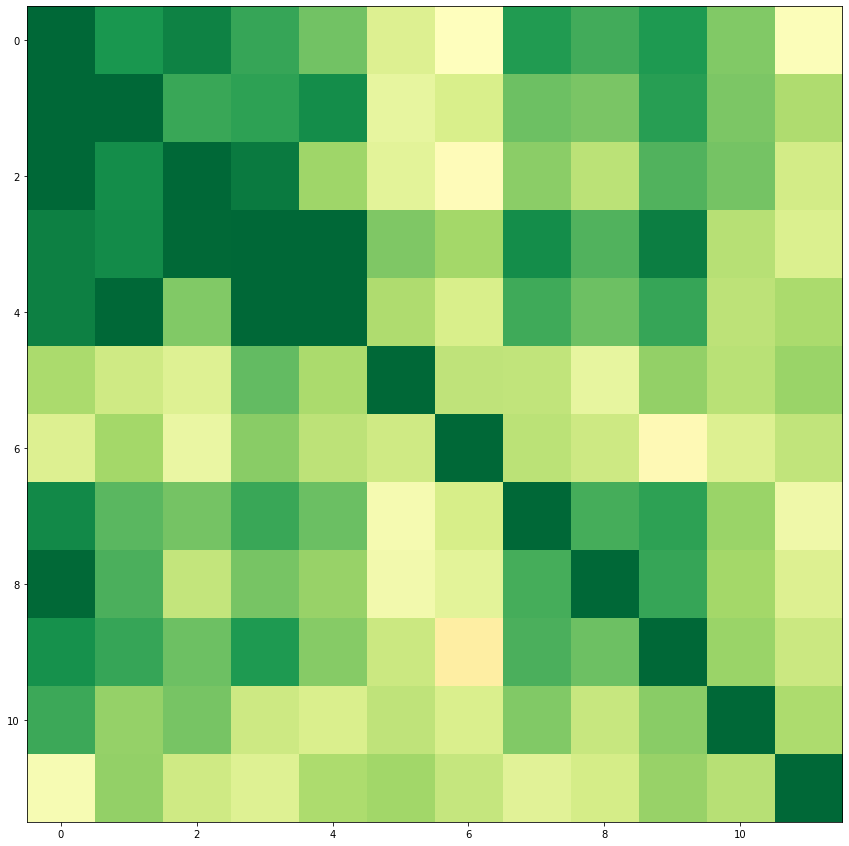

In [44]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the middle that does not seem to be relevant to other eras, and the
#  overall performance seems to decrease a bit over time.
plt.figure(figsize=(15, 15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")


Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [45]:
def our_score(preds, dtrain):
    return "score", -numpy.corrcoef(preds, dtrain.get_label())[0,1]

dtrain = xgboost.DMatrix(df1[features], df1[target])
dtest = xgboost.DMatrix(df2[features], df2[target])
dall = xgboost.DMatrix(df[features], df[target])

[00:21:46] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:21:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.22323	train-score:-0.03421	test-rmse:0.22328	test-score:-0.01337
[10]	train-rmse:0.22306	train-score:-0.05772	test-rmse:0.22321	test-score:-0.02571
[20]	train-rmse:0.22295	train-score:-0.06850	test-rmse:0.22319	test-score:-0.02912
[30]	train-rmse:0.22285	train-score:-0.07647	test-rmse:0.22318	test-score:-0.03066
[40]	train-rmse:0.22277	train-score:-0.08137	test-rmse:0.22317	test-score:-0.03168
[50]	train-rmse:0.22270	train-score:-0.08727	test-rmse:0.22317	test-score:-0.0320

<AxesSubplot:>

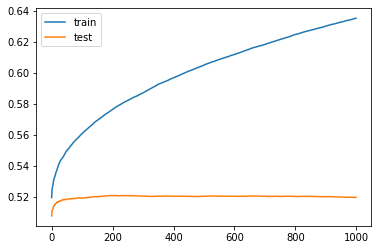

In [46]:
param = {
    'max_depth': 3,
    'eta': 0.1,
    'silent': 1,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'nthread': -1,
}
evals_result = {}
bst = xgboost.train(
    params=param,
    dtrain=dtrain,
    feval=our_score,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    evals_result=evals_result,
    verbose_eval=10,
)

(0.5 - 0.57*pandas.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot()

<AxesSubplot:>

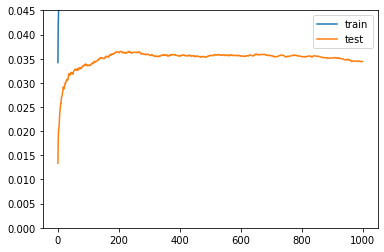

In [47]:
(-pandas.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot(ylim=[0,0.045])

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [48]:
df1 = df[eras <= eras.median()]
df2 = df[eras > eras.median()]

In [49]:
models = [
    linear_model.LinearRegression(),
] + [
    linear_model.ElasticNet(alpha=alpha)
    for alpha in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]
] + [
    xgboost.XGBRegressor(n_jobs=-1),
    xgboost.XGBRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000),
    xgboost.XGBRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000),
    xgboost.XGBRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000, max_depth=5),
    xgboost.XGBRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.001, n_estimators=10000, max_depth=5),
]

In [50]:
for model in models:
    print(" -- ", model)   
    model.fit(df1[features], df1[target])
    outsample = numerai_score(df2[target], pandas.Series(model.predict(df2[features]), index=df2.index))
    insample = numerai_score(df1[target], pandas.Series(model.predict(df1[features]), index=df1.index))
    print(
        f"outsample: {outsample}, insample: {insample}"
    )
    print()

 --  LinearRegression()
outsample: 0.028025599207338932, insample: 0.06275168899240303

 --  ElasticNet(alpha=0.01)
outsample: 0.0009542737561177415, insample: 0.002958177208411678

 --  ElasticNet(alpha=0.005)
outsample: 0.0009542737561177415, insample: 0.002958177208411678

 --  ElasticNet(alpha=0.002)
outsample: 0.013745176938453646, insample: 0.02888067072641634

 --  ElasticNet(alpha=0.001)
outsample: 0.021311952919572837, insample: 0.042267294451933425

 --  ElasticNet(alpha=0.0005)
outsample: 0.02707000883589404, insample: 0.04969819985437264

 --  ElasticNet(alpha=0.0002)
outsample: 0.02974822373493759, insample: 0.05624191073941452

 --  ElasticNet(alpha=0.0001)
outsample: 0.029904272306853837, insample: 0.05903326020576007

 --  ElasticNet(alpha=5e-05)
outsample: 0.029366586757797603, insample: 0.060866534133698136

 --  ElasticNet(alpha=2e-05)
outsample: 0.02872155214335588, insample: 0.0622410782806831

 --  ElasticNet(alpha=1e-05)
outsample: 0.02842539152755156, insample: 

## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 


In [51]:
import numpy as np
import scipy

In [52]:
# Train a standard xgboost on half the train eras
xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=-1)
xgb.fit(df1[features], df1[target])
xgb_preds = xgb.predict(df2[features])

### Our predictions have correlation > 0.2 in either direction for some single features!
Sure hope those features continue to act as they have in the past!

In [53]:
corr_list = []
for feature in features:
    corr_list.append(numpy.corrcoef(df2[feature], xgb_preds)[0,1])
corr_series = pandas.Series(corr_list, index=features)
corr_series.describe()

count    310.000000
mean       0.048410
std        0.081645
min       -0.229774
25%        0.004178
50%        0.045796
75%        0.108645
max        0.232514
dtype: float64

In [54]:
from sklearn.preprocessing import MinMaxScaler

def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(numpy.linalg.pinv(exposures).dot(scores))
    return scores / scores.std(ddof=0)

def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)

def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]

In [55]:
df2["preds"] = xgb_preds
df2["preds_neutralized"] = df2.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], features, 0.5) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1

<ipython-input-55-61794ff4a72a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = xgb_preds
<ipython-input-55-61794ff4a72a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = df2.groupby("era").apply(
<ipython-input-55-61794ff4a72a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

### Now our single feature exposures are much smaller

In [56]:
corr_list2 = []
for feature in features:
    corr_list2.append(numpy.corrcoef(df2[feature], df2["preds_neutralized"])[0,1])
corr_series2 = pandas.Series(corr_list2, index=features)

In [57]:
corr_series2.describe()

count    310.000000
mean       0.036113
std        0.053180
min       -0.146887
25%        0.007757
50%        0.033742
75%        0.075340
max        0.155376
dtype: float64

### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [58]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.w(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.03680684965579
score for balanced feature expo: 0.03288299396994347
std for high feature exposure: 0.0381442021815143
std for balanced feature expo: 0.03130221750795125
sharpe for high feature exposure: 0.9649395596384392
sharpe for balanced feature expo: 1.0505004625180525


In [59]:
balanced_scores_per_era.describe()

count    56.000000
mean      0.032883
std       0.031586
min      -0.065154
25%       0.013038
50%       0.030797
75%       0.061884
max       0.091098
dtype: float64

In [60]:
unbalanced_scores_per_era.describe()

count    56.000000
mean      0.036807
std       0.038489
min      -0.085174
25%       0.014656
50%       0.033550
75%       0.062175
max       0.112687
dtype: float64